# PREAMBLE
<script
  src="https://cdn.mathjax.org/mathjax/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML"
  type="text/javascript">
</script>

In [1]:
import numpy as np
import pandas as pd
import numpy.linalg as la
import seaborn as sns
sns.set()
sns.set_style("ticks")
from validphys.api import API
from validphys.loader import Loader
from matplotlib import pyplot as plt
from matplotlib import cm
l = Loader()
import yaml

# Definition of the input

In [2]:
fit="221207-ern-002"

theory_max = 236
theory_mid = 205
theory_min = 201

alphas_step_size = 0.003
alphas_central = 0.119

covmat_scaling_factor = 1

# COMPUTATION OF $\alpha_s$

In [3]:
fitpath = API.fit(fit=fit).path 
filterpath = fitpath / 'filter.yml'
import yaml
with open(filterpath) as f:
    filterfile = yaml.safe_load(f)
pdf_ori=filterfile['theorycovmatconfig']['pdf']

In [4]:
common_dict = dict(dataset_inputs={"from_": "fit"},
            fit=fit,
            use_cuts="fromfit",
            metadata_group="nnpdf31_process",)

In [5]:
#Inputs for central theory
inps_central = dict(theoryid=theory_mid,pdf=pdf_ori,**common_dict)

In [6]:
#Inputs for plus theory
inps_plus = dict(theoryid=theory_max,pdf=pdf_ori,**common_dict)

In [7]:
#Inputs for minus theory
inps_minus = dict(theoryid=theory_min,pdf=pdf_ori,**common_dict)

In [8]:
#Inputs for central theory
inps_central_fit = dict(theoryid=theory_mid,pdf={"from_": "fit"},**common_dict)

In [9]:
#Experimental covariance matrix
C = API.groups_covmat(**inps_central)

In [10]:
dsindex=API.groups_index(**inps_central)

In [11]:
datth_central = API.group_result_table_no_table(**inps_central)


-- Reading COMMONDATA for Dataset: ATLASPHT15_SF
nData: 53 nSys: 2
-- COMMONDATA Files for ATLASPHT15_SF successfully read.

LHAPDF 6.4.0 loading all 101 PDFs in set 221206-ern-002
221206-ern-002, version 1; 101 PDF members

-- Reading COMMONDATA for Dataset: ATLAS_1JET_8TEV_R06_DEC
nData: 171 nSys: 677
-- COMMONDATA Files for ATLAS_1JET_8TEV_R06_DEC successfully read.


-- Reading COMMONDATA for Dataset: CMS_1JET_8TEV
nData: 239 nSys: 293
-- COMMONDATA Files for CMS_1JET_8TEV successfully read.


-- Reading COMMONDATA for Dataset: ATLAS_2JET_7TEV_R06
nData: 90 nSys: 474
-- COMMONDATA Files for ATLAS_2JET_7TEV_R06 successfully read.


-- Reading COMMONDATA for Dataset: CMS_2JET_7TEV
nData: 54 nSys: 88
-- COMMONDATA Files for CMS_2JET_7TEV successfully read.


-- Reading COMMONDATA for Dataset: CHORUSNUPb_dw_ite
nData: 607 nSys: 1014
-- COMMONDATA Files for CHORUSNUPb_dw_ite successfully read.


-- Reading COMMONDATA for Dataset: CHORUSNBPb_dw_ite
nData: 607 nSys: 114
-- COMMONDATA Fil

In [12]:
datth_plus = API.group_result_table_no_table(**inps_plus)

In [13]:
datth_minus = API.group_result_table_no_table(**inps_minus)

In [14]:
datth_central_fit = API.group_result_table_no_table(**inps_central_fit)

LHAPDF 6.4.0 loading all 501 PDFs in set 221207-ern-002
221207-ern-002, version 1; 501 PDF members


In [15]:
dat_central=datth_central["data_central"]
th_replicas_fit=datth_central_fit.iloc[:,2:].to_numpy()

Computation of Eqs.(3.37)-(3.38) in [arXiv:2105.05114](https://arxiv.org/pdf/2105.05114.pdf)

In [16]:
beta_tilde = np.sqrt(covmat_scaling_factor)*(alphas_step_size/np.sqrt(2))*np.array([1,-1])
S_tilde = beta_tilde@beta_tilde

In [17]:
delta_plus  = (np.sqrt(covmat_scaling_factor)/np.sqrt(2))*(datth_plus["theory_central"] - datth_central["theory_central"]).to_numpy()
delta_minus = (np.sqrt(covmat_scaling_factor)/np.sqrt(2))*(datth_minus["theory_central"] - datth_central["theory_central"]).to_numpy()
beta = [delta_plus,delta_minus]
S_hat = beta_tilde@beta

In [18]:
S = np.outer(delta_plus,delta_plus)+np.outer(delta_minus,delta_minus)
S = pd.DataFrame(S,index=dsindex,columns=dsindex)
S = pd.DataFrame(S.values, index=C.index, columns=C.index)

In [19]:
invcov = la.inv(C+S)

In [20]:
# Different from the prediction of the mean PDF (i.e. replica0)
mean_prediction = np.mean(th_replicas_fit[:],axis=1)

In [21]:
X = np.zeros_like(C.values)
for i in range(th_replicas_fit.shape[1]):
    X += np.outer((th_replicas_fit[:,i]-mean_prediction),(th_replicas_fit[:,i]-mean_prediction))
X *= 1/th_replicas_fit.shape[1]

Final result

In [22]:
# BUG: dat_central should become average over data replicas
delta_T_tilde = S_hat@invcov@(dat_central-mean_prediction)
P_tilde = S_hat.T@invcov@X@invcov@S_hat + (S_tilde - S_hat.T@invcov@S_hat)
pred = alphas_central + delta_T_tilde
unc  = np.sqrt(P_tilde)

In [23]:
aa = pd.read_csv(
    fitpath / 'tables/datacuts_theory_theorycovmatconfig_theory_covmat_custom.csv', 
    sep='\t',encoding='utf-8', index_col=2,header=3,skip_blank_lines=False,
);
if np.allclose(S.to_numpy(),aa.to_numpy()[:,2:].astype('float64')):
    print(rf"Prediction for $\alpha_s$: {pred:.5f} +/- {unc:.5f}")
else:
    print("Reconstructed theory covmat, S, is note the same as the stored covmat!")

Prediction for $\alpha_s$: 0.12005 +/- 0.00036


In [38]:

preds = []
uncs = []
for count in range(100,datth_central_fit.iloc[:,2:].to_numpy().shape[1]+1,10):
    th_replicas_fit=datth_central_fit.iloc[:,2:count+2].to_numpy()
    mean_prediction = np.mean(th_replicas_fit[:],axis=1)
    X = np.zeros_like(C.values)
    for i in range(count):
        X += np.outer((th_replicas_fit[:,i]-mean_prediction),(th_replicas_fit[:,i]-mean_prediction))
    X *= 1/count
    delta_T_tilde = S_hat@invcov@(dat_central-mean_prediction)
    P_tilde = S_hat.T@invcov@X@invcov@S_hat + (S_tilde - S_hat.T@invcov@S_hat)
    pred = alphas_central + delta_T_tilde
    unc  = np.sqrt(P_tilde)
    preds.append(pred)
    uncs.append(unc)
    print(f"{count}, {unc}")

100, 0.00030672165605358416
110, 0.00031984558922461026
120, 0.0003232604843931274
130, 0.00033540940019092163
140, 0.0003392253802164897
150, 0.00033401064272943937
160, 0.0003308657921102037
170, 0.0003320780755491582
180, 0.00033576989329571103
190, 0.0003362818519357446
200, 0.0003368025773914425
210, 0.0003449022138772755
220, 0.0003423323492127949
230, 0.00034242706576368483
240, 0.0003387514498523103
250, 0.0003364733843708257
260, 0.00033300077518080227
270, 0.0003307282275105283
280, 0.00033384958994530837
290, 0.0003313948053120448
300, 0.0003340429657348674
310, 0.0003305171347720152
320, 0.0003320989144340305
330, 0.00033349445928574853
340, 0.0003349019818916991
350, 0.0003326885025395395
360, 0.0003406051966789452
370, 0.00034394595288299995
380, 0.0003498092990891153
390, 0.00034835092144219293
400, 0.0003547726212964449
410, 0.000352678104959937
420, 0.0003552636023951186
430, 0.0003596459351315847
440, 0.0003589986944718927
450, 0.00035862279125867843
460, 0.0003593915

In [39]:
boot_preds = []
boot_uncs = []
for count in range(100,datth_central_fit.iloc[:,2:].to_numpy().shape[1]+1,10):
    boot_preds_tmp = []
    for _ in range(1000):
        replicas = np.random.randint(count,size=int(count*0.9))+2
        th_replicas_fit=datth_central_fit.iloc[:,replicas].to_numpy()
        mean_prediction = np.mean(th_replicas_fit[:],axis=1)
        delta_T_tilde = S_hat@invcov@(dat_central-mean_prediction)
        pred = alphas_central + delta_T_tilde
        boot_preds_tmp.append(pred)
    boot_preds.append(np.mean(boot_preds_tmp))
    boot_uncs.append(np.std(boot_preds_tmp))
    print(count)

100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500


In [55]:

count=500
uncs_on_uncs_500=[]
uncs_on_cv_500=[]
for ii in range(500):
    replicas = np.random.randint(count,size=int(count*0.9))+2
    th_replicas_fit=datth_central_fit.iloc[:,replicas].to_numpy()
    mean_prediction = np.mean(th_replicas_fit[:],axis=1)
    X = np.zeros_like(C.values)
    for i in range(replicas.size):
        X += np.outer((th_replicas_fit[:,i]-mean_prediction),(th_replicas_fit[:,i]-mean_prediction))
    X *= 1/replicas.size
    P_tilde = S_hat.T@invcov@X@invcov@S_hat + (S_tilde - S_hat.T@invcov@S_hat)
    delta_T_tilde = S_hat@invcov@(dat_central-mean_prediction)
    pred = alphas_central + delta_T_tilde
    unc  = np.sqrt(P_tilde)
    uncs_on_uncs_500.append(unc)
    uncs_on_cv_500.append(pred)
    print(ii)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [64]:
count=100
uncs_on_uncs_100=[]
uncs_on_cv_100=[]
for ii in range(500):
    replicas = np.random.randint(count,size=int(count*0.9))+2
    th_replicas_fit=datth_central_fit.iloc[:,replicas].to_numpy()
    mean_prediction = np.mean(th_replicas_fit[:],axis=1)
    X = np.zeros_like(C.values)
    for i in range(replicas.size):
        X += np.outer((th_replicas_fit[:,i]-mean_prediction),(th_replicas_fit[:,i]-mean_prediction))
    X *= 1/replicas.size
    P_tilde = S_hat.T@invcov@X@invcov@S_hat + (S_tilde - S_hat.T@invcov@S_hat)
    delta_T_tilde = S_hat@invcov@(dat_central-mean_prediction)
    pred = alphas_central + delta_T_tilde
    unc  = np.sqrt(P_tilde)
    uncs_on_uncs_100.append(unc)
    uncs_on_cv_100.append(pred)
    print(ii)

0
1
2
3
4
5
6
7
8
9


In [65]:
mean_500 = np.mean(np.array(uncs_on_cv_500))
mean_unc_plus_500 = np.mean(np.array(uncs_on_cv_500)+np.array(uncs_on_uncs_500))
mean_unc_minus_500 = np.mean(np.array(uncs_on_cv_500)-np.array(uncs_on_uncs_500))
std_unc_plus_500 = np.std(np.array(uncs_on_cv_500)+np.array(uncs_on_uncs_500))
std_unc_minus_500 = np.std(np.array(uncs_on_cv_500)-np.array(uncs_on_uncs_500))

mean_100 = np.mean(np.array(uncs_on_cv_100))
mean_unc_plus_100 = np.mean(np.array(uncs_on_cv_100)+np.array(uncs_on_uncs_100))
mean_unc_minus_100 = np.mean(np.array(uncs_on_cv_100)-np.array(uncs_on_uncs_100))
std_unc_plus_100 = np.std(np.array(uncs_on_cv_100)+np.array(uncs_on_uncs_100))
std_unc_minus_100 = np.std(np.array(uncs_on_cv_100)-np.array(uncs_on_uncs_100))

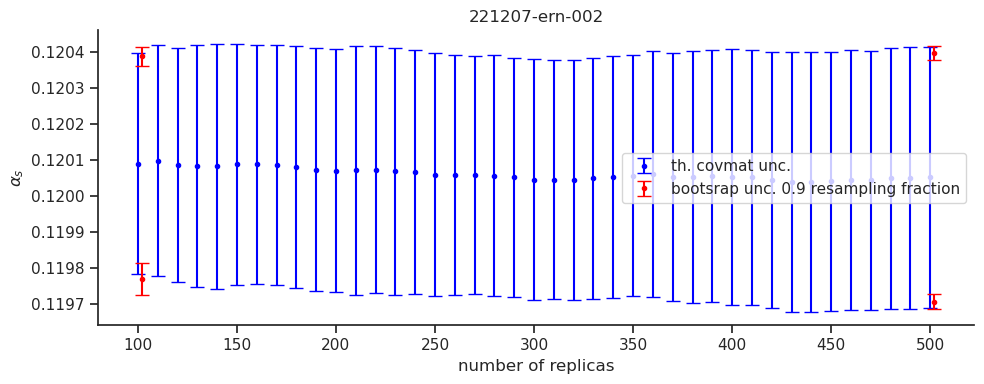

In [66]:
counts = [i for i in range(100,datth_central_fit.iloc[:,2:].to_numpy().shape[1]+1,10)]

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,4)
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.errorbar(counts, preds, uncs, fmt='.', color='blue', capsize=5, label="th. covmat unc.")
# plt.errorbar(np.array(counts)+2, boot_preds, boot_uncs, fmt='.', color='red', capsize=5, label="bootsrap unc. 0.9 resampling fraction")
plt.errorbar(500+2, mean_unc_plus_500, std_unc_plus_500, fmt='.', color='red', capsize=5, label="bootsrap unc. 0.9 resampling fraction")
plt.errorbar(500+2, mean_unc_minus_500, std_unc_minus_500, fmt='.', color='red', capsize=5)
plt.errorbar(100+2, mean_unc_plus_100, std_unc_plus_100, fmt='.', color='red', capsize=5)
plt.errorbar(100+2, mean_unc_minus_100, std_unc_minus_100, fmt='.', color='red', capsize=5)
plt.title(fit)
plt.ylabel(r"$\alpha_s$")
plt.xlabel("number of replicas")
plt.legend()
plt.tight_layout()
plt.savefig("alphas_stability.pdf")